# Anomalous diffusion from normal diffusion
> We show how to study anomalous diffusion by characterizing the Brownian motion properties through time.

# Scaled Brownian motion


## Generate the data

In this analysis, we use scaled Brownian motion (SBM) trajectories, which present an aging phenomenon that dicreases the diffusion coefficient with time. 

In [ ]:
n_traj, max_t, exponents, models, dim = 6000, 200, np.array([0.1, 0.5]), [4], 2
trajs = create_trajectories(n_traj, max_t, exponents, models, dim, noise=None)
trajs = tensor(trajs[:, 2:].reshape((n_traj, dim, max_t)).transpose(0, 2, 1))

Let's predict the diffusion coefficient for these trajectories.

In [ ]:
bs = 128
n_batch = np.ceil(n_traj/bs).astype(int)
batches = [trajs[i*bs:(i+1)*bs] for i in range(n_batch)]

In [ ]:
preds = [to_detach(learn_diff.model(xb.cuda()).squeeze()) for xb in batches]
preds = torch.cat(preds, axis=0)

Text(0.5, 0, 't')

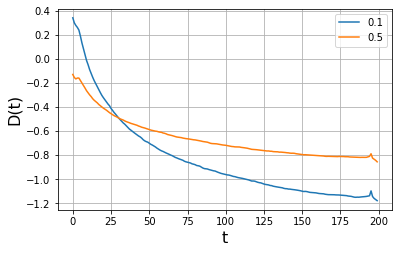

In [ ]:
plt.figure(figsize=(6, 3.7))
plt.plot(preds[:n_traj//2].mean(axis=0), label=exponents[0])
plt.plot(preds[n_traj//2:].mean(axis=0), label=exponents[1])
plt.grid()
plt.legend()
plt.ylabel("D(t)", fontsize=16)
plt.xlabel("t", fontsize=16)

In [ ]:
file_name = "preds_sbm"
data_path = DATA_PATH/file_name
with open(data_path.with_suffix('.pkl'), 'wb') as f:
    pickle.dump(preds, f, protocol=pickle.HIGHEST_PROTOCOL)

# Annealed transit time model

## Generate the data

In [ ]:
n_traj, max_t, sigma, gamma = 10000, 200, 1.16, 1.38
trajs, Ds = create_fixed_attm_trajs(n_traj, max_t, sigma, gamma)
trajs, Ds = tensor(trajs).transpose(2, 1), tensor(Ds)

In [ ]:
bs = 128
n_batch = np.ceil(n_traj/bs).astype(int)
batches = [trajs[i*bs:(i+1)*bs] for i in range(n_batch)]

In [ ]:
preds = [to_detach(learn_diff.model(xb.cuda().float()).squeeze()) for xb in tqdm(batches)]
preds = torch.cat(preds, axis=0)

  0%|          | 0/79 [00:00<?, ?it/s]

In [ ]:
file_name = "preds_attm"
data_path = DATA_PATH/file_name
with open(data_path.with_suffix('.pkl'), 'wb') as f:
    pickle.dump({'pred': preds, 'true': Ds}, f, protocol=pickle.HIGHEST_PROTOCOL)